# Price Predict

## A PyTorch-based machine learning tool to predict the approximate price of a product given its details

Hello guys! I'm Aamish, a '26 who's looking to join the dev team at DALI, and this is a project in which I analyse the `Sample - Superstore.csv` dataset provided for the DALI Challenges and train a machine learning model (a neural network in our case) to predict the price of a product given its details.

Our analysis will include scouting out correlation between multiple factors and choosing a good mix of features to include for training our model. This will then be followed by a process of pruning down some of those features - some which might correlate with each other and some to balance computational efficiency with accuracy.

Subsequently, we will preprocess our data, clean it out a bit, remove bad data and just improve the overall uniformity of the data.

And after all that stuff, we'll train our model, performing some hyperparameter tuning using the `Optuna` framework. Through this search process, we will explore what a globally optimal model for this problem might look like, how hyperparameter changes affect the model and how do we go about training a better performing model.

With this project, my hope is to present some of my machine learning skills in practice, revealing my deep understanding of deep learning and general ML topics and maybe a thing or two along the way myself.

I hope you guys like this, and if you want to clarify something in this project, such as the usage of some code or API that might be a bit confusing, or if you are not able to replicate my results, feel free to reach out to my [email](mailto:aamish.a.beg.26@dartmouth.edu).

### 1. Loading in the data

The first thing we need to do is load the data in, which we will subsequently analyse, process and feed into the model.

In [ ]:
# Load in the data

import pandas as pd

superstore_data = pd.read_csv("https://raw.githubusercontent.com/dali-lab/dali-challenges/main/data/Sample%20-%20Superstore.csv")

superstore_data.head()

,Unnamed: 0,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,0,1.0,CA-2016-152156,11/8/2016,11/11/2016,NaN,CG-12520,Claire Gute,Consumer,United States,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,NaN,2.0,0.0,41.9136
1,1,NaN,NaN,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3.0,0.0,219.5820
2,2,3.0,NaN,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2.0,0.0,6.8714
3,3,4.0,US-2015-108966,10/11/2015,10/18/2015,Standard Class,NaN,Sean O'Donnell,Consumer,United States,...,33311.0,South,NaN,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5.0,NaN,-383.0310
4,4,5.0,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,NaN,Consumer,United States,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2.0,0.2,2.5164


### 2. Cleaning the data

Now that we have the data, we need to do some housekeeping to make sure it's accurate and ingestable by the model.

In [ ]:
# We'll start by dropping ID columns, since, logically speaking, we do not expect them to have
# any correlation with any of the product's important attributes, including the price

superstore_data = superstore_data.drop(columns=['Unnamed: 0', 'Row ID', 'Order ID', 'Customer ID', 'Customer Name', 'Product ID'])

superstore_data.head()

,Order Date,Ship Date,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,11/8/2016,11/11/2016,NaN,Consumer,United States,Henderson,Kentucky,42420.0,South,Furniture,Bookcases,Bush Somerset Collection Bookcase,NaN,2.0,0.0,41.9136
1,11/8/2016,11/11/2016,Second Class,Consumer,United States,Henderson,NaN,42420.0,South,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3.0,0.0,219.5820
2,6/12/2016,6/16/2016,Second Class,Corporate,United States,Los Angeles,California,90036.0,West,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2.0,0.0,6.8714
3,10/11/2015,10/18/2015,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5.0,NaN,-383.0310
4,10/11/2015,10/18/2015,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2.0,0.2,2.5164


Firstly, let's deal with the categorical variables, firstly checking which ones are eligible for one-hot encoding.



In [ ]:
categorical_features = ['Segment', 'Ship Mode', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category', 'Postal Code']
print('Number of rows in database: ' + str(len(superstore_data)))
print('Number of rows in database (after dropping NA-containing rows): ' + str(len(superstore_data.dropna())))
superstore_data[categorical_features].nunique()

Number of rows in database: 9994
Number of rows in database (after dropping NA-containing rows): 1829


Segment           3
Ship Mode         4
Country           1
City            524
State            49
Region            4
Category          3
Sub-Category     17
Postal Code     627
dtype: int64

We can see that `Country` has only one value, so there's not much point in using that as a predictive value. `Segment`, `Region`, `ShipMode` and `Category` have very low cardinalities (unique values), and are perfect for one-hot encoding.

I prefer one-hot encoding over label encoding in such discrete unranked values since label encoding bakes in a hierarchy and a relational value structure between values that might not be reflected in the real world data.

Also, we can't drop NA-containing rows, since that leaves a very small subset of data for us. We might want to explore alternatives to that for handling NA values.

In [ ]:
from numpy.core import numeric
# To handle NA data, we might explore 3 options
# 1. Filling it with the median of all values in that column
# 2. Filling it with the mean of all values in that column
# 3. Filling it with a constant

# 2 might be susceptible to outliers and 3 might disrupt training relations. Median seems like a good tradeoff
# Let's see how much data is left if we median out the numeric columns and drop NA for categorical ones.
print('Number of rows in database (after filling numeric rows with median and dropping NA-containing rows): ' + str(len((superstore_data.fillna(superstore_data.median(numeric_only=True))).dropna())))

Number of rows in database (after filling numeric rows with median and dropping NA-containing rows): 3091


Looks like we will have to deal with categorical NAs too, considering that otherwise we lose half of our data. Let's try some imputation methods for that.

In [ ]:
# A great way would be to use the most common class in every category
superstore_data = superstore_data.fillna(superstore_data.median(numeric_only=True)).dropna()
superstore_data = superstore_data.apply(lambda x: x.fillna(x.value_counts().index[0]))
superstore_data.head()

,Order Date,Ship Date,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
2,6/12/2016,6/16/2016,Second Class,Corporate,United States,Los Angeles,California,90036.0,West,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2.0,0.0,6.8714
3,10/11/2015,10/18/2015,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5.0,0.2,-383.0310
4,10/11/2015,10/18/2015,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2.0,0.2,2.5164
8,6/9/2014,6/14/2014,Standard Class,Consumer,United States,Los Angeles,California,90032.0,West,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,18.5040,3.0,0.2,5.7825
14,11/22/2015,11/26/2015,Standard Class,Home Office,United States,Fort Worth,Texas,76106.0,Central,Office Supplies,Appliances,Holmes Replacement Filter for HEPA Air Cleaner...,54.7920,3.0,0.8,-123.8580


Finally, we'll convert everything to the correct type and remove categorical values that might not be very useful due to high cardinality. While `Sub-Category` has 17 values, I would advocate towards dropping it in favor of maintaining low dimensionality of data.

Order Date and Shipping Date will be converted to DateTime types.

In [ ]:
datetime_columns = ['Order Date', 'Ship Date']
categorical_features_to_remove = ['Sub-Category', 'Postal Code', 'City', 'State', 'Country', 'Product Name']

superstore_data[datetime_columns] = pd.to_datetime(superstore_data[datetime_columns].stack()).unstack()
superstore_data_clean = superstore_data.drop(categorical_features_to_remove, axis = 1)

superstore_data_clean.head()

,Order Date,Ship Date,Ship Mode,Segment,Region,Category,Sales,Quantity,Discount,Profit
2,2016-06-12,2016-06-16,Second Class,Corporate,West,Office Supplies,14.6200,2.0,0.0,6.8714
3,2015-10-11,2015-10-18,Standard Class,Consumer,South,Furniture,957.5775,5.0,0.2,-383.0310
4,2015-10-11,2015-10-18,Standard Class,Consumer,South,Office Supplies,22.3680,2.0,0.2,2.5164
8,2014-06-09,2014-06-14,Standard Class,Consumer,West,Office Supplies,18.5040,3.0,0.2,5.7825
14,2015-11-22,2015-11-26,Standard Class,Home Office,Central,Office Supplies,54.7920,3.0,0.8,-123.8580


As a final cleaning step, let's remove duplicate rows, if there are any. It might not remove any rows, but this step would act as a precautionary measure in case duplicates exist.

In [ ]:
print('Number of rows before dulpicate removal: ', len(superstore_data_clean))
superstore_data_clean.drop_duplicates(inplace=True)
print('Number of rows after dulpicate removal: ', len(superstore_data_clean))

Number of rows before dulpicate removal:  3091
Number of rows after dulpicate removal:  3091


Now that we have cleaned up our data, let's move on to data transformation.

### 3. Initial Correlation Analysis

Now let's use a correlation maxtrix to test how correlated our continuous columns are, and a chi-square test to test indepedence of categorical variables.

<Axes: >

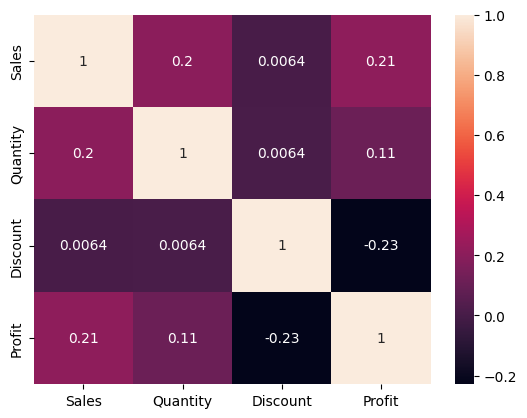

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(superstore_data_clean.corr(numeric_only=True), annot=True)

We can see a few trends which we can try to interpret.

Sales are highly correlated with quantity, which makes sense since if we sell a higher quantity of items, it leads to higher sales value. Sales and quantity seem pretty independent of discount, presumably because how much discount is provided is more arbitrary, and does not depend much on sales figures as much as the seller's psyche and policies.

Relating values to profit, we can see that increased sales or quantity translate to increased profit, as with higher value or quantity, profit margins may increase. Interestingly, discount has the strongest effect on profit, decreasing it a lot. My initial thoughts were that discounts wouldn't affect profits much as the seller would take this effect into account and provide lower discounts or increase quantity to stabilize profit margins, but apparently not! It does make some sense since discount reduces profit, but I thought that the seller would account for that.

Now, let's do a chi-squares test of independence with our categorical variables.

For every pair of categorical value, we assume our Null Hypothesis to be the fact they are completely independent. We select a commonly-used `p` (measure of evidence) value (`p = 0.05`). If `p` exceeds that, we can sufficiently say our Null Hypothesis was incorrect and that the two variables are indeed dependent on each other.

In [ ]:
from scipy.stats import chi2_contingency

# We will later encode these, hence the name
categorical_features_to_encode = [feature for feature in categorical_features if feature not in categorical_features_to_remove]

def calculate_dependence(cols):
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            _, p, _, _ = chi2_contingency(pd.crosstab(superstore_data_clean[cols[i]], superstore_data_clean[cols[j]]))
            isNot = '' if p > 0.05 else ' NOT'
            print(f'{cols[i]} and {cols[j]} are{isNot} independent. (p-value = {p})')
calculate_dependence(categorical_features_to_encode)

Segment and Ship Mode are NOT independent. (p-value = 0.035004449492147115)
Segment and Region are independent. (p-value = 0.7002294545557133)
Segment and Category are independent. (p-value = 0.7687503555886886)
Ship Mode and Region are NOT independent. (p-value = 0.03993558421408882)
Ship Mode and Category are independent. (p-value = 0.7997780085083498)
Region and Category are NOT independent. (p-value = 0.01748715894113007)


Let's analyse these results.

`Segment` does not depend on `Ship Mode`, suggesting that shipping is  different for different segment of customer. `Segment` does not depend on `Region` and `Category`, suggesting that people from a wide variety of places are buying a wide variety of things.

`Ship Mode` depends on the `Region`, which means people from different places receive the good in different modes of shipping, regardless of category (since `Ship Mode` is independent of `Category`).

Finally, where the customer is correlates to what they buy, suggested by the dependence of `Region` and `Category`.

These statements are not authoritative, and are mere reflections and opinions upon the data.

### 4. Data Transformation

We now have our cleaned data in `superstore_data_clean`. It's time to transform our dataset into something that a model can ingest, and maybe do some feature engineering to make sure that our data has good predictive features.

Firstly, we picked out our categorical variables while cleaning which we wanted to one-hot encode. Let's do that now.

In [ ]:
# pd.get_dummies does the one-hot encoding for us with a simple call
superstore_data_transformed = pd.DataFrame(superstore_data_clean)
superstore_data_transformed = pd.get_dummies(superstore_data_transformed, columns=categorical_features_to_encode, drop_first=True)
superstore_data_transformed.head()

,Order Date,Ship Date,Sales,Quantity,Discount,Profit,Segment_Corporate,Segment_Home Office,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Region_East,Region_South,Region_West,Category_Office Supplies,Category_Technology
2,2016-06-12,2016-06-16,14.6200,2.0,0.0,6.8714,1,0,0,1,0,0,0,1,1,0
3,2015-10-11,2015-10-18,957.5775,5.0,0.2,-383.0310,0,0,0,0,1,0,1,0,0,0
4,2015-10-11,2015-10-18,22.3680,2.0,0.2,2.5164,0,0,0,0,1,0,1,0,1,0
8,2014-06-09,2014-06-14,18.5040,3.0,0.2,5.7825,0,0,0,0,1,0,0,1,1,0
14,2015-11-22,2015-11-26,54.7920,3.0,0.8,-123.8580,0,1,0,0,1,0,0,0,1,0


Now, we should do some **feature engineering**.

One idea I have is that the time it took for delivery might be correlated with the overall price (as added fees). Let's use `Order Date` and `Ship Date` to create a column called `Days To Ship`. We'll drop `Order Date` and `Ship Date` afterwards, because they have a high cardinality and don't really give much in terms of predictive power.

In [ ]:
superstore_data_transformed['Days To Ship'] = (superstore_data_transformed['Ship Date'] - superstore_data_transformed['Order Date']).dt.days
superstore_data_transformed.drop(['Ship Date', 'Order Date'], inplace=True, axis=1)

superstore_data_transformed.head()

,Sales,Quantity,Discount,Profit,Segment_Corporate,Segment_Home Office,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Region_East,Region_South,Region_West,Category_Office Supplies,Category_Technology,Days To Ship
2,14.6200,2.0,0.0,6.8714,1,0,0,1,0,0,0,1,1,0,4
3,957.5775,5.0,0.2,-383.0310,0,0,0,0,1,0,1,0,0,0,7
4,22.3680,2.0,0.2,2.5164,0,0,0,0,1,0,1,0,1,0,7
8,18.5040,3.0,0.2,5.7825,0,0,0,0,1,0,0,1,1,0,5
14,54.7920,3.0,0.8,-123.8580,0,1,0,0,1,0,0,0,1,0,4


The data looks good now, and we can start our model training process. Let's do our training-testing split, and then start training our model.

In [ ]:
X = superstore_data_transformed.drop(['Profit'], axis=1)
y = superstore_data_transformed['Profit']
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size = 0.2, random_state = 0)

### 5. Training PyTorch model and hyperparameter optimization with Optuna

In this section, we will train our PyTorch model, and will be picking our hyperparameters with the help of a hyperparameter tuning framework called Optuna.

While most machine learning projects focus a lot on training a model and then predicting a variable, our project is going to be a bit different, a newer kind of study, if you will.

**Our objective is to figure out what hyperparameters will generate the best model.**

We will train PyTorch's Sequential neural network model on our data, split as 80% for training and 20% for testing. We will take a few commonly-used range of values to test our model with. We will train it on the testing data, and then test it on our validation data. We will do this for a fixed number of epochs, and keep passing in different hyperparameters. Optuna uses the Tree-structured Parzen Estimator Sampler to ensure an eager search in the hyperparameter search space and optimize the model without requiring too many trials.

Firstly, we'll import our required libraries, and set up our experiments.

Then, we'll load our data into `TensorDataset`-type objects for ingestion by the `DataLoader` object, which in turn allows us to train our

In [ ]:
!pip install optuna

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import optuna
import torch.utils.data as data_utils
from optuna.trial._state import TrialState

# A few constants for our training loop
EPOCHS = 30
DEVICE = torch.device('cpu')

# Passing our data to DataLoaders
train = data_utils.TensorDataset(torch.FloatTensor(X_train_df.values), torch.FloatTensor(y_train_df.values))
test = data_utils.TensorDataset(torch.FloatTensor(X_test_df.values), torch.FloatTensor(y_test_df.values))
train_loader = data_utils.DataLoader(train, batch_size=10, shuffle=True)
test_loader = data_utils.DataLoader(test, batch_size=10, shuffle=True)


# This is our objective function we're looking to minimize
def objective(trial):

    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []

    # We know we have 14 columns in X
    in_features = 14
    for i in range(n_layers):
        out_features = trial.suggest_int(f'n_units_l{i}', 4, 128)
        layers.append(torch.nn.Linear(in_features, out_features))
        layers.append(torch.nn.ReLU())
        in_features = out_features
    layers.append(torch.nn.Linear(in_features, 1))
    model = torch.nn.Sequential(*layers).to(DEVICE)

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    loss_function = nn.MSELoss()

    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()

        Y_hat = model(test.tensors[0])
        train_loss = loss_function(Y_hat, test.tensors[1])

        # Validation loss
        error = train_loss.item()

        trial.report(error, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return error

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

pruned_trials = [t for t in study.trials if t.state == TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-10-21 21:39:41,011] A new study created in memory with name: no-name-0347a41b-caea-4e9a-94ca-60c81f5507e1
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([619])) that is different to the input size (torch.Size([619, 1])). This will likel

Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  18
  Number of complete trials:  31
Best trial:
  Value:  9007.3583984375
  Params: 
    n_layers: 2
    n_units_l0: 38
    n_units_l1: 83
    optimizer: Adam
    lr: 0.04059081780111964


And with this, we have found a very optimal set of hyperparameters to perform regression on our dataset. The final value is printed after all the trials, and gives us a highly-optimized hyperparameter set, which would have a lower loss than other hyperparameter sets we tried.

This concludes this project. I hope this presents my ML and Deep Learning skills well, and I'm excited to join DALI soon!